In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error 


In [5]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv',index_col='date')
df.drop(columns=['Unnamed: 0','state'], inplace=True)
df = df.groupby('date').sum()
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')
date_index = df.index


In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases_new'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}' )
print(f'Critical Values: {result[4]}')

ADF Statistic: -4.176908825015194
p-value: 0.0007207787314412768
Critical Values: {'1%': -3.4346453058155175, '5%': -2.8634371105641443, '10%': -2.5677799947325988}


In [7]:
#scaler = MinMaxScaler()
#columns = df.columns
#scaled_Df= scaler.fit_transform(df.to_numpy())
#df = pd.DataFrame(scaled_Df,columns=columns,index=date_index)

In [8]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

Training data shape: (774, 26)
Testing data shape: (774, 26)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

---

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df['cases_new'], period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

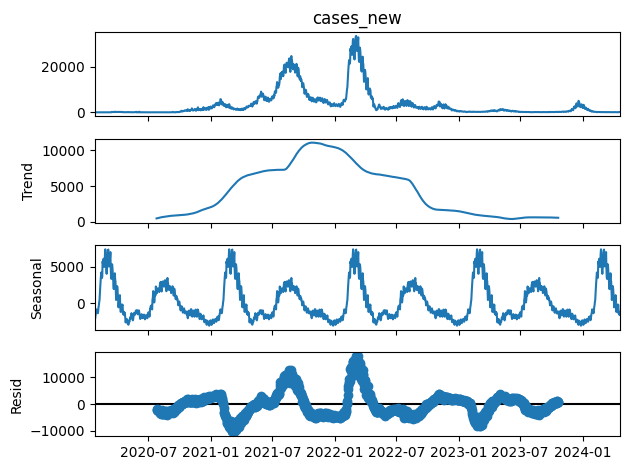

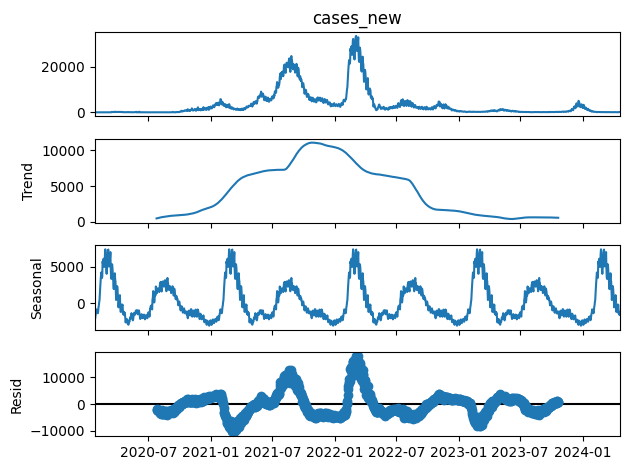

In [10]:
result.plot()

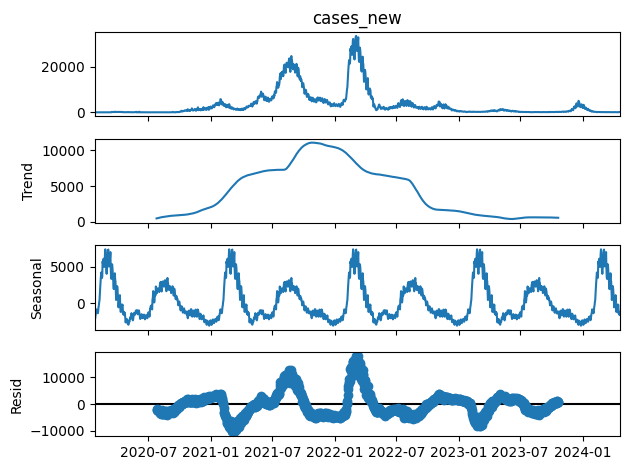

In [11]:
data_diff = df.diff()
data_diff = df.dropna()

dec = seasonal_decompose(data_diff['cases_new'],period = 365).plot()
plt.show()

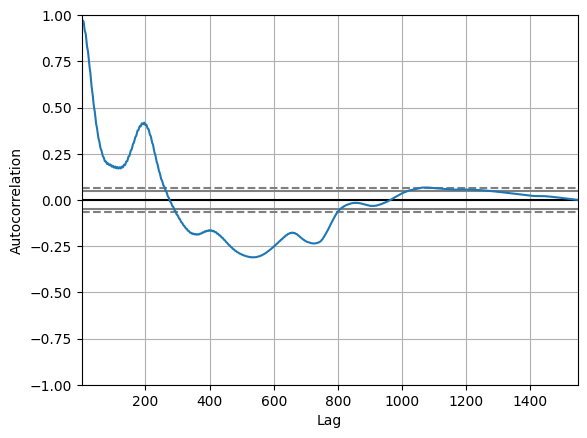

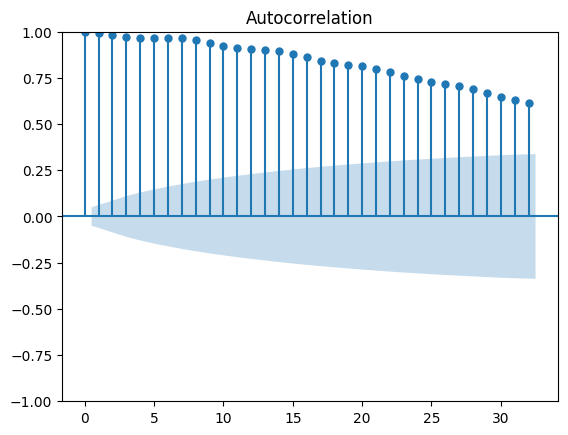

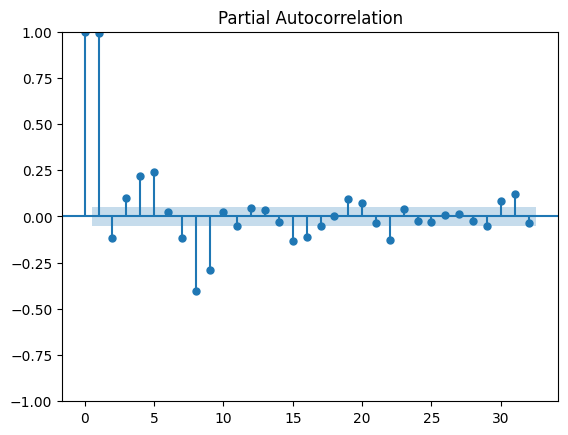

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['cases_new'])
plot_acf(df['cases_new'])
plot_pacf(df['cases_new'])
plt.show()

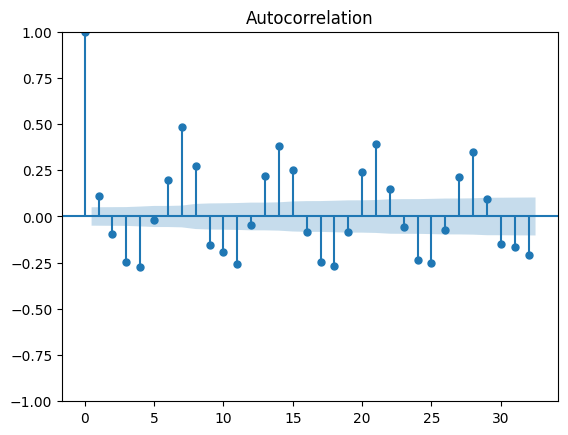

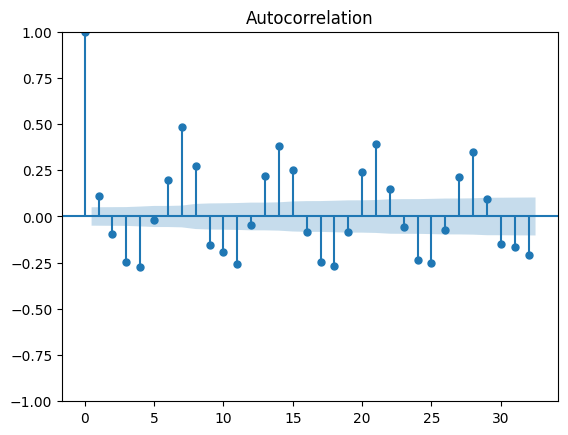

In [13]:
plot_acf(df['cases_new'].diff().dropna())

### ARIMA

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train_data['cases_new'], 
                      m=7,                                   
                      seasonal=True,  
                      stationary=True,
                      d=None,            
                      test='adf',
                      start_p=0, start_q=0,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=13686.896, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=15870.201, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14322.917, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16173.428, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=15003.064, Time=0.42 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.52 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=14129.783, Time=1.80 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=14466.802, Time=1.01 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=12364.270, Time=0.92 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=12490.538, Time=0.71 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=12386.1

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  774
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6174.047
Date:                           Mon, 08 Jul 2024   AIC                          12358.093
Time:                                   13:56:24   BIC                          12381.351
Sample:                               01-25-2020   HQIC                         12367.042
                                    - 03-08-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9899      0.003    360.620      0.000       0.984       0.995
ma.L1         -0.0974      0.018     -5.423      0.000      -0.133      -0.062
ar.S.L7        0.9539      0.017     55.458      0.000       0.920       0.988
ma.S.L7       -0.6523      0.028    -22.902      0.000      -0.708      -0.596
sigma2      4.882e+05   9668.192     50.497      0.000    4.69e+05    5.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4669.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             518.08   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
n_periods = len(test_data)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = test_data.index
print(forecast)

2022-03-09    33388.646836
2022-03-10    34994.208374
2022-03-11    35183.082748
2022-03-12    34818.836229
2022-03-13    31952.098599
                  ...     
2024-04-16     1026.427082
2024-04-17     1029.527482
2024-04-18     1029.945670
2024-04-19     1022.546680
2024-04-20     1012.147444
Freq: D, Length: 774, dtype: float64


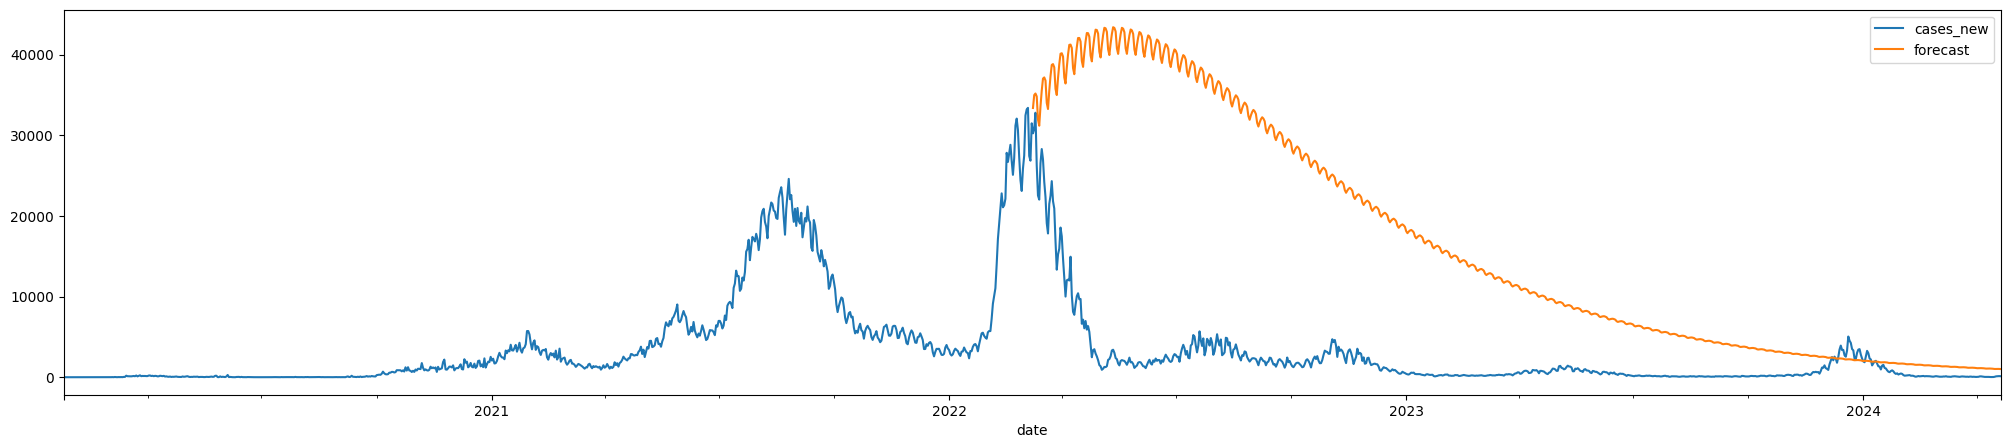

In [17]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
vis_df['forecast'] = forecast
vis_df[['cases_new','forecast']].plot(figsize=(25,5))
plt.show()

----

In [18]:
from prophet import Prophet

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [19]:
# Modifying df to fit prophet model

#Training Data
trainprop_df = train_data
trainprop_df['ds'] = train_data.index
trainprop_df.rename(columns={'cases_new':'y'},inplace=True)
trainprop_df = trainprop_df.reset_index(drop=True)


#Testing Data
testprop_df = test_data
testprop_df['ds'] = test_data.index
testprop_df = testprop_df.reset_index(drop=True)

print([trainprop_df.head(),testprop_df.head()])

[   y  cases_recovered  cases_active  cases_unvax  cases_pvax  cases_fvax  \
0  4                0             4            4           0           0   
1  0                0             4            0           0           0   
2  0                0             4            0           0           0   
3  0                0             4            0           0           0   
4  3                0             7            3           0           0   

   cases_0_4  cases_5_11  cases_12_17  cases_18_29  ...  daily  \
0          0           0            0            0  ...    0.0   
1          0           0            0            0  ...    0.0   
2          0           0            0            0  ...    0.0   
3          0           0            0            0  ...    0.0   
4          1           0            0            0  ...    0.0   

   admitted_covid_hospital  admitted_total_hospital  \
0                     96.0                    176.0   
1                     96.0         

C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_8196\3904746340.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df['ds'] = train_data.index
C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_8196\3904746340.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df.rename(columns={'cases_new':'y'},inplace=True)
C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_8196\3904746340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [20]:
trainprop_df

,y,cases_recovered,cases_active,cases_unvax,cases_pvax,cases_fvax,cases_0_4,cases_5_11,cases_12_17,cases_18_29,...,daily,admitted_covid_hospital,admitted_total_hospital,discharged_covid_hospital,discharged_total_hospital,hosp_covid_hospital,icu_covid,vent_covid,cases_new_capita,ds
0,4,0,4,4,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,1.054241e-06,2020-01-25
1,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-26
2,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-27
3,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-28
4,3,0,7,3,0,0,1,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,9.829920e-07,2020-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,33209,26352,305017,5164,617,10958,1880,2285,1517,8977,...,84379.0,1994.0,2626.0,1517.0,1932.0,7130.0,348.0,211.0,1.889241e-02,2022-03-04
770,33406,27143,311213,4899,617,10847,1800,2211,1508,9184,...,70817.0,2020.0,2574.0,1523.0,1959.0,7391.0,372.0,226.0,1.815530e-02,2022-03-05
771,27435,30335,308258,4055,516,8670,1573,1757,1110,7310,...,58853.0,1742.0,2213.0,1346.0,1727.0,7416.0,380.0,216.0,1.579195e-02,2022-03-06
772,26856,30726,304311,3820,550,8778,1537,1661,1188,7235,...,66038.0,1871.0,2425.0,1481.0,1863.0,7463.0,368.0,223.0,1.505910e-02,2022-03-07


In [21]:
m = Prophet(growth = 'logistic')

# Add additional regressors, excluding 'ds', 'y', and 'cap

trainprop_df['cap'] = df['cases_new'].max()
m.fit(trainprop_df)

13:56:25 - cmdstanpy - INFO - Chain [1] start processing
13:56:25 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
testprop_df['cap'] = df['cases_new'].max()
testprop_df['floor'] = 0
forecastProphet = m.predict(testprop_df)

In [23]:
forecastProphet

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-09,16733.331945,33406,13294.144204,23638.707834,16733.331945,16733.331945,1651.619018,1651.619018,1651.619018,74.583376,74.583376,74.583376,1577.035642,1577.035642,1577.035642,0.0,0.0,0.0,18384.950963
1,2022-03-10,16782.503449,33406,13134.440952,23714.295901,16782.503447,16782.503447,1556.683931,1556.683931,1556.683931,295.766368,295.766368,295.766368,1260.917563,1260.917563,1260.917563,0.0,0.0,0.0,18339.187380
2,2022-03-11,16831.673575,33406,13057.225767,23135.123368,16831.673590,16831.673590,1257.709962,1257.709962,1257.709962,309.358919,309.358919,309.358919,948.351043,948.351043,948.351043,0.0,0.0,0.0,18089.383537
3,2022-03-12,16880.841471,33406,12685.640110,22545.889952,16880.841527,16880.841527,834.536811,834.536811,834.536811,191.452725,191.452725,191.452725,643.084086,643.084086,643.084086,0.0,0.0,0.0,17715.378283
4,2022-03-13,16930.006285,33406,12076.518802,22169.655425,16930.006389,16930.006389,136.645737,136.645737,136.645737,-211.960620,-211.960620,-211.960620,348.606356,348.606356,348.606356,0.0,0.0,0.0,17066.652022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,2024-04-16,33050.181025,33406,26865.578639,37433.555535,33049.683383,33050.706878,-907.203281,-907.203281,-907.203281,-118.109887,-118.109887,-118.109887,-789.093394,-789.093394,-789.093394,0.0,0.0,0.0,32142.977745
770,2024-04-17,33052.247746,33406,27105.843971,37429.731342,33051.751371,33052.771583,-727.283720,-727.283720,-727.283720,74.583376,74.583376,74.583376,-801.867097,-801.867097,-801.867097,0.0,0.0,0.0,32324.964025
771,2024-04-18,33054.302590,33406,27927.476166,37480.512258,33053.807485,33054.824767,-522.473542,-522.473542,-522.473542,295.766368,295.766368,295.766368,-818.239910,-818.239910,-818.239910,0.0,0.0,0.0,32531.829048
772,2024-04-19,33056.345624,33406,27557.376340,37528.634097,33055.852690,33056.865971,-527.683540,-527.683540,-527.683540,309.358919,309.358919,309.358919,-837.042460,-837.042460,-837.042460,0.0,0.0,0.0,32528.662084


In [24]:
forecastProphet = forecastProphet[['ds','yhat']]
forecastProphet = forecastProphet.set_index('ds')
forecastProphet

,yhat
ds,
2022-03-09,18384.950963
2022-03-10,18339.187380
2022-03-11,18089.383537
2022-03-12,17715.378283
2022-03-13,17066.652022
...,...
2024-04-16,32142.977745
2024-04-17,32324.964025
2024-04-18,32531.829048


<Axes: xlabel='date', ylabel='cases_new'>

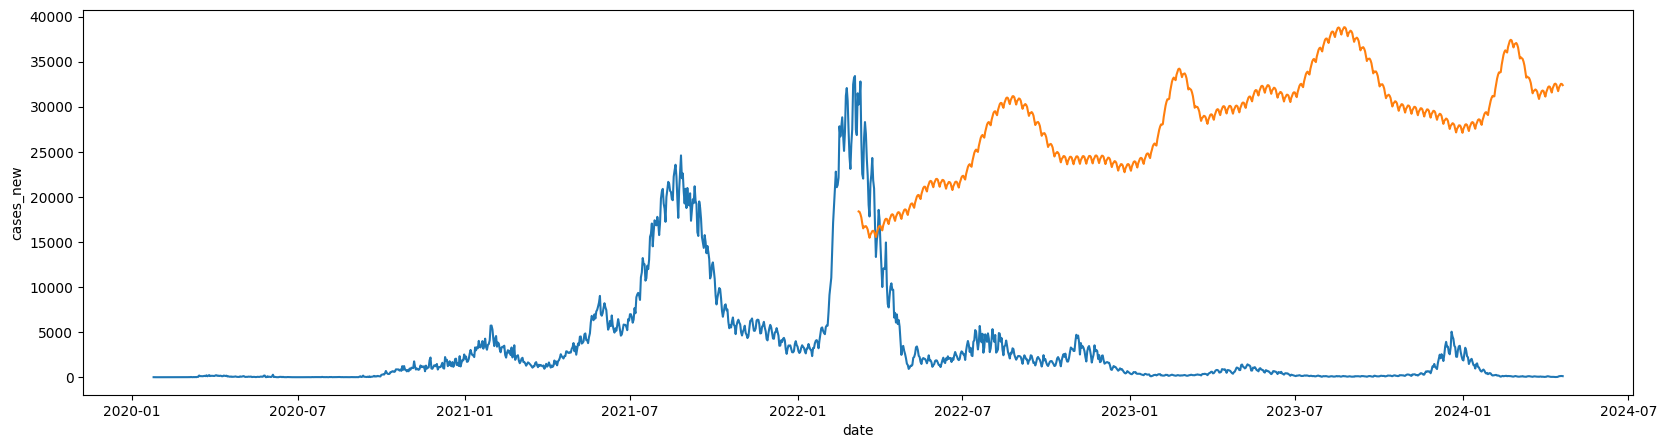

In [25]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,5))
sns.lineplot(vis_df['cases_new'])
sns.lineplot(forecastProphet['yhat'])

----

### LSTM

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

In [52]:
trainX = []
trainY = []

future = 1
past = 14

In [53]:
for i in range(past,len(df_scaled)-future+1):
    trainX.append(df_scaled[i-past:i,0:df.shape[1]])
    trainY.append(df_scaled[i+future-1:i+future,0])

In [54]:
trainX, trainY =np.array(trainX),np.array(trainY)

In [55]:
trainX.shape

(1534, 14, 26)

In [58]:
trainY.shape

(1534, 1)

In [57]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [97]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 14, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,745 (139.63 KB)

 Trainable params: 35,745 (139.63 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
history = model.fit(trainX,trainY,epochs=40,batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3313 - val_loss: 0.0089
Epoch 2/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1590 - val_loss: 0.0086
Epoch 3/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1266 - val_loss: 0.0076
Epoch 4/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0861 - val_loss: 0.0066
Epoch 5/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0671 - val_loss: 0.0075
Epoch 6/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0585 - val_loss: 0.0072
Epoch 7/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0388 - val_loss: 0.0080
Epoch 8/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0510 - val_loss: 0.0080
Epoch 9/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0516 - val_loss: 0.0078
Epoch 10/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0511 - val_loss: 0.0098
Epoch 11/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0909 - val_loss: 0.0086
Epoch 12/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0729 - val_l

In [79]:
future_dates = len(test_data)
forecast_dates = test_data.index
forecast = model.predict(trainX[-future_dates:])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [80]:
forecast

array([[ 3.79044366e+00],
       [ 3.71211982e+00],
       [ 3.69351363e+00],
       [ 3.78411198e+00],
       [ 3.48383069e+00],
       [ 3.20488930e+00],
       [ 3.05848622e+00],
       [ 3.24893212e+00],
       [ 3.30265808e+00],
       [ 3.23237967e+00],
       [ 3.06759667e+00],
       [ 2.81328797e+00],
       [ 2.60529041e+00],
       [ 2.41685843e+00],
       [ 2.44320273e+00],
       [ 2.45632219e+00],
       [ 2.49526310e+00],
       [ 2.41588473e+00],
       [ 2.31695199e+00],
       [ 2.06512284e+00],
       [ 1.78541064e+00],
       [ 1.71616447e+00],
       [ 1.64680815e+00],
       [ 1.69044411e+00],
       [ 1.68963778e+00],
       [ 1.54055548e+00],
       [ 1.36701465e+00],
       [ 1.16698635e+00],
       [ 1.10123348e+00],
       [ 1.02973580e+00],
       [ 9.84790444e-01],
       [ 1.03785598e+00],
       [ 9.26413298e-01],
       [ 7.93742597e-01],
       [ 6.92602038e-01],
       [ 6.36314988e-01],
       [ 6.25288785e-01],
       [ 6.26961887e-01],
       [ 6.1

In [81]:
forecast_copies = np.repeat(forecast,df.shape[1],axis=-1)
pred = scaler.inverse_transform(forecast_copies)[:,0]

In [99]:
lstm_result = pd.DataFrame({'forecast':pred},index=forecast_dates)

In [100]:
lstm_result

,forecast
date,
2022-03-09,25515.554688
2022-03-10,25058.792969
2022-03-11,24950.287109
2022-03-12,25478.630859
2022-03-13,23727.474609
...,...
2024-04-16,73.630867
2024-04-17,86.577400
2024-04-18,97.003181


In [93]:
vis_df['forecast']

date
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
              ..
2024-04-16   NaN
2024-04-17   NaN
2024-04-18   NaN
2024-04-19   NaN
2024-04-20   NaN
Freq: D, Name: forecast, Length: 1548, dtype: float32

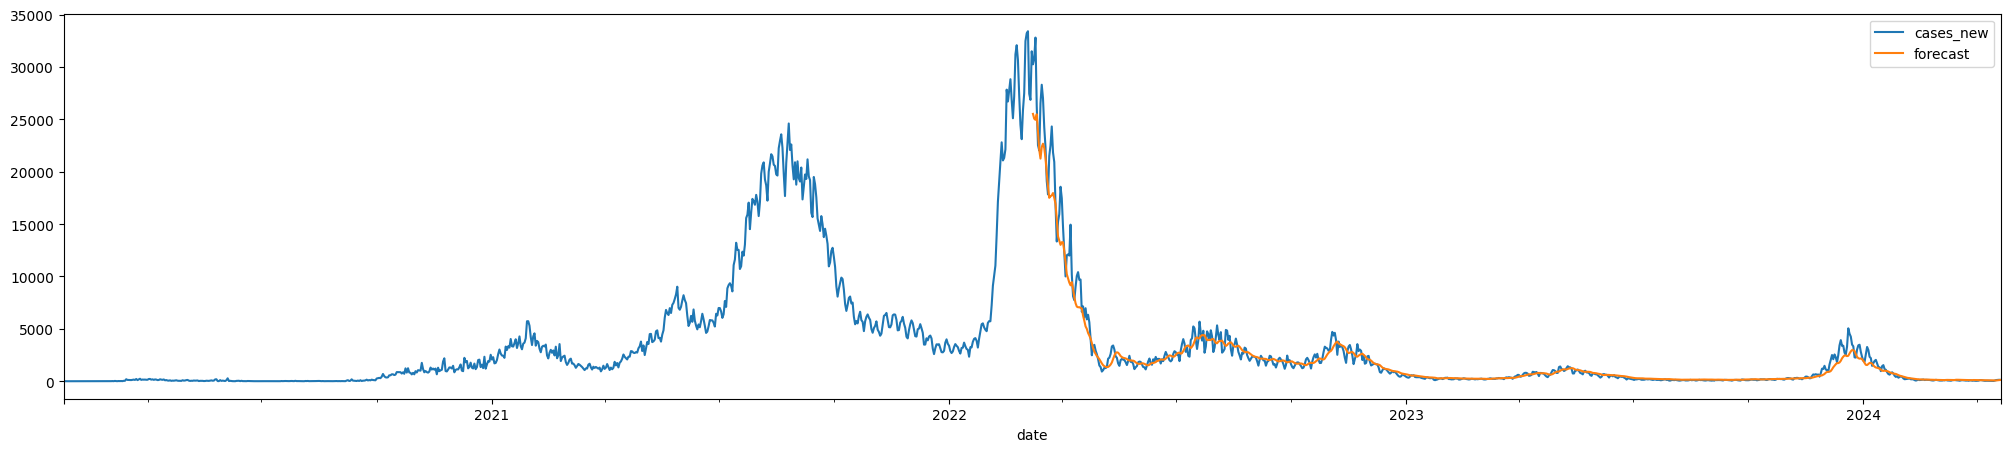

In [101]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
vis_df['forecast'] = lstm_result['forecast']
vis_df[['cases_new','forecast']].plot(figsize=(25,5))
plt.show()